In [1]:
import os, sys

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from src.utils import fileio
from src import settings

path = "/srv/milky/drosophila-datasets/drosophila-isolation/data/processed/1_0_find_interactions/CS_10D"
TREATMENTS = ['CS_10D', 'Cs_5DIZ', 'CsCh']
renamed_treatments = {
        'CsCh': 'Young',
        'CS_10D': 'Old',
        'Cs_5DIZ': 'Isolated'
    }

files = fileio.load_files_from_folder(path)
# for file_name, file_path in files.items():
#     plt.figure(figsize=(15, 4))
#     df = pd.read_csv(file_path)

#     for idx, node_1_value in enumerate(df["node_1"].unique(), start=1):
#         node_1_df = df[df["node_1"] == node_1_value]
#         for _, interaction in node_1_df.iterrows():
#             plt.fill_between([interaction["start_of_interaction"]/24, interaction["end_of_interaction"]/24],
#                              [idx - 0.12, idx - 0.12],
#                              [idx + 0.12, idx + 0.12],
                            #  alpha=0.35, color='blue')

    # plt.title(file_name)
    # plt.xlabel('Time (seconds)')
    # plt.ylabel('Fly')
    # plt.ylim(0.2, len(df["node_1"].unique()) + 0.2)
    # plt.yticks(range(1, len(df["node_1"].unique()) + 1), list(range(1,13))) # df["node_1"].unique()
    # plt.show()

In [2]:
def calculate_burstiness(event_times):
    if len(event_times) < 2: raise ValueError("At least two event times are required to calculate inter-event times.")
    
    inter_event_times = np.diff(sorted(event_times))
    mu = np.mean(inter_event_times)
    sigma = np.std(inter_event_times)
    
    if sigma + mu == 0:
        return 0.0
    
    burstiness = (sigma - mu) / (sigma + mu)
    return burstiness

config = fileio.get_config(settings.CONFIG_NAME)
OUTPUT_DIR = os.path.join(settings.REPORTS_DIR, "figures", "distance_interaction_comparison")
os.makedirs(OUTPUT_DIR, exist_ok=True)
TIME_WINDOW = config["TIME_WINDOW"]

for TREATMENT in TREATMENTS:
    path = f"/srv/milky/drosophila-datasets/drosophila-isolation/data/processed/1_0_find_interactions/{TREATMENT}"
    files = fileio.load_files_from_folder(path)
    burstnest_values = []
    for file_name, file_path in files.items():
        df = pd.read_csv(file_path)
        event_times = df['start_of_interaction'].to_list()
        burstiness = calculate_burstiness(event_times)
        burstnest_values.append(burstiness)
        
    print(f"{renamed_treatments[TREATMENT]} {sum(burstnest_values) / len(burstnest_values)}")

Old 0.13315284042956543
Isolated 0.08710632906262208
Young 0.08875619859434822


In [12]:
import os, sys

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from src.utils import fileio
from src import settings


def calculate_burstiness(event_times):
    if len(event_times) < 2: raise ValueError("At least two event times are required to calculate inter-event times.")
    inter_event_times = np.diff(sorted(event_times))
    mu = np.mean(inter_event_times)
    sigma = np.std(inter_event_times)
    if sigma + mu == 0: return 0.0
    
    return (sigma - mu) / (sigma + mu)


path = "/srv/milky/drosophila-datasets/drosophila-isolation/data/processed/1_0_find_interactions/CS_10D"
TREATMENTS = ['CS_10D', 'Cs_5DIZ', 'CsCh']
renamed_treatments = {'CsCh': 'Young', 'CS_10D': 'Old', 'Cs_5DIZ': 'Isolation'}

files = fileio.load_files_from_folder(path)
nodes = ['fly1', 'fly2', 'fly3', 'fly4', 'fly5', 'fly6', 'fly7', 'fly8', 'fly9', 'fly10', 'fly11', 'fly12']
df_node_burstnes_real = pd.DataFrame()
df_node_burstnes_shuffled = pd.DataFrame()

for TREATMENT in TREATMENTS:
    path = f"/srv/milky/drosophila-datasets/drosophila-isolation/data/processed/1_0_find_interactions/{TREATMENT}"
    files = fileio.load_files_from_folder(path)
    burstnest_values = []
    files = {k: files[k] for k in sorted(files)}

    for file_name, file_path in files.items():
        df = pd.read_csv(file_path)
        event_times = df['start_of_interaction'].to_list()
        burstiness = calculate_burstiness(event_times)

        shuffled_times = np.random.permutation(df['start_of_interaction'].values)
        df_shuffled = df.copy()
        df_shuffled['start_of_interaction'] = shuffled_times
        df_shuffled = df_shuffled.sort_values(by="start_of_interaction").reset_index(drop=True)

        b_real = []
        b_shuffled = []
        for node in nodes:
            filtered_df = df[df['node_1'] == node]
            event_times = filtered_df['start_of_interaction'].to_list()
            if event_times: burstiness = calculate_burstiness(event_times)
            burstnest_values.append(burstiness)
            b_real.append(burstiness)

            filtered_df = df_shuffled[df_shuffled['node_1'] == node]
            event_times = filtered_df['start_of_interaction'].to_list()
            if event_times: burstiness = calculate_burstiness(event_times)
            burstnest_values.append(burstiness)
            b_shuffled.append(burstiness)

        res_real = pd.DataFrame({"b": b_real})
        res_real = res_real.rename_axis('fly')
        res_real = res_real.reset_index()
        res_real['group'] = file_name.replace('.csv', '')
        res_real['treatment'] = TREATMENT
        df_node_burstnes_real = pd.concat([df_node_burstnes_real, res_real], axis=0)

        res_shuffled = pd.DataFrame({"b": b_shuffled})
        res_shuffled = res_shuffled.rename_axis('fly')
        res_shuffled = res_shuffled.reset_index()
        res_shuffled['group'] = file_name.replace('.csv', '')
        res_shuffled['treatment'] = TREATMENT
        df_node_burstnes_shuffled = pd.concat([df_node_burstnes_shuffled, res_shuffled], axis=0)

df_node_burstnes_real['treatment'] = df_node_burstnes_real['treatment'].replace(renamed_treatments)
df_node_burstnes_real = df_node_burstnes_real.set_index(['treatment', 'group', 'fly'])
df_node_burstnes_shuffled = df_node_burstnes_shuffled.set_index(['treatment', 'group', 'fly'])


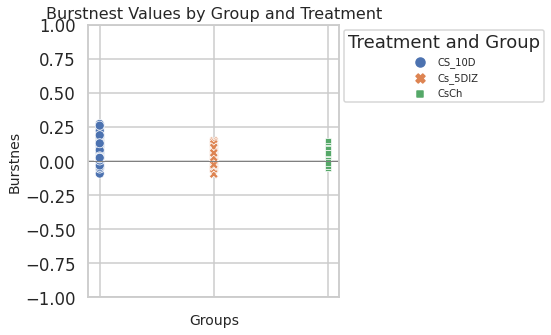

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=df_node_burstnes_shuffled,
    x='treatment',  # Separate groups along the x-axis
    y='b',  # Plot values on the y-axis
    hue='treatment',  # Color by treatment
    style='treatment',  # Optional: Different markers by treatment
)

plt.title('Burstnest Values by Group and Treatment', fontsize=16)
plt.xlabel('Groups', fontsize=14)
plt.ylabel('Burstnes', fontsize=14)
plt.legend(title='Treatment', fontsize=12)
plt.ylim(-1, 1)
plt.gca().set_xticklabels([]) 
plt.axhline(0, color='gray', linestyle='-', linewidth=1)
plt.legend(title='Treatment and Group', fontsize=10, bbox_to_anchor=(1.0, 1), loc='upper left')
plt.tight_layout()
plt.show()

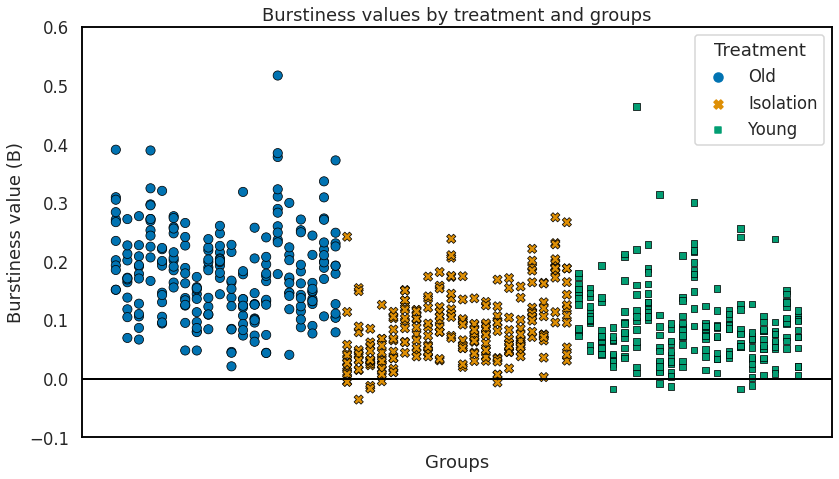

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_theme(style="whitegrid", context="talk")


plt.figure(figsize=(12, 7))
sns.scatterplot(
    data=df_node_burstnes_real,
    x='group',  # Separate groups along the x-axis
    y='b',  # Plot values on the y-axis
    hue='treatment',  # Color by treatment
    style='treatment',  # Optional: Different markers by treatment
    palette='colorblind',  # Use a color palette for treatments
    s=85,  # Marker size
    edgecolor='black'
)

plt.title('Burstiness values by treatment and groups')
plt.xlabel('Groups')
plt.ylabel('Burstiness value (B)')
plt.legend(title='Treatment')
plt.gca().set_xticklabels([]) 
plt.axhline(0, color='black', linestyle='-', linewidth=2)
plt.ylim(-0.1, 0.6)
plt.legend(title='Treatment', loc='upper right', facecolor='white')
plt.grid(False)
plt.tight_layout()

for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.savefig('figures/burstiness.svg', dpi=500)
plt.savefig('figures/burstiness.png', dpi=500)
plt.show()

In [7]:
df_node_burstnes_real

b
treatment group                      fly          
CS_10D    CTRL10_14_02_2024_11_04_A1 0    0.309297
                                     1    0.151422
                                     2    0.201932
                                     3    0.234796
                                     4    0.192978
...                                            ...
CsCh      CsCh_A4_28_04_2023-11_20   7    0.070703
                                     8    0.052198
                                     9    0.082760
                                     10   0.098215
                                     11   0.071127

[720 rows x 1 columns]

In [11]:
from scipy.stats import wilcoxon

stat, p_value = wilcoxon(df_node_burstnes_real, df_node_burstnes_shuffled)

print(f"Wilcoxon test statistic: {stat}, p-value: {p_value}")

Wilcoxon test statistic: [12237.], p-value: [2.09763398e-98]


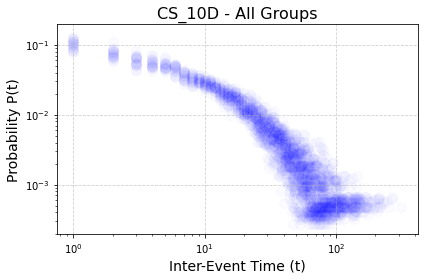

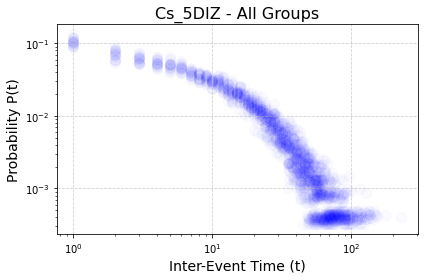

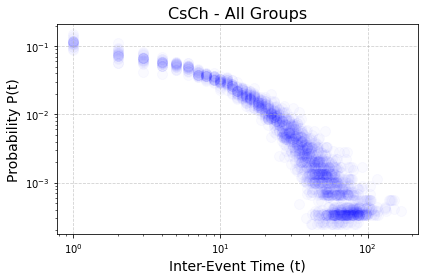

In [29]:
for TREATMENT in TREATMENTS:
    path = f"/srv/milky/drosophila-datasets/drosophila-isolation/data/processed/1_0_find_interactions/{TREATMENT}"
    files = fileio.load_files_from_folder(path)
    all_unique_times = []
    all_probabilities = []
    for group_name, group_path in files.items():
        df = pd.read_csv(group_path)
        event_times = df['start_of_interaction'].to_list()
        inter_event_times = np.diff(sorted(event_times))
        def degree_probability(times):
            unique_times, counts = np.unique(times, return_counts=True)
            probabilities = counts / sum(counts)  # Normalize counts to get probabilities
            return unique_times, probabilities

        unique_times, probabilities = degree_probability(inter_event_times)
        all_unique_times.extend(unique_times)
        all_probabilities.extend(probabilities)

    plt.figure(figsize=(6, 4))
    plt.scatter(all_unique_times, all_probabilities, color='blue', label='P(t)', s=100, alpha=0.02)
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'{TREATMENT} - All Groups', fontsize=16)
    plt.xlabel('Inter-Event Time (t)', fontsize=14)
    plt.ylabel('Probability P(t)', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()


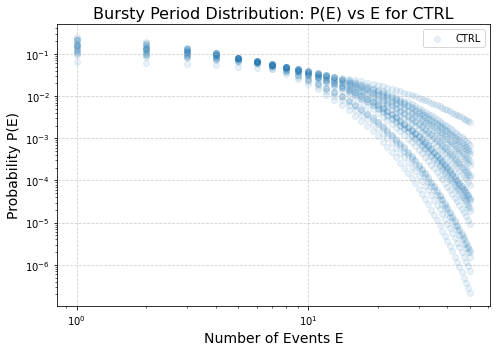

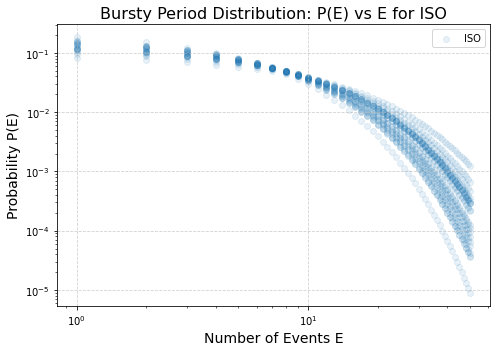

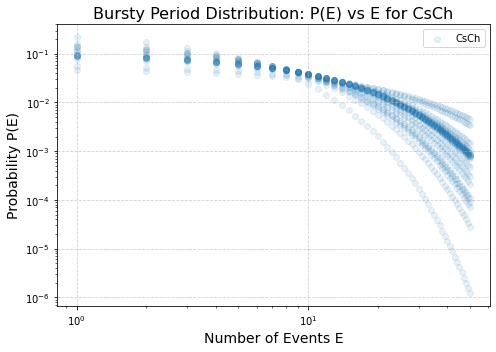

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Define function to calculate the probability distribution of inter-event times
def degree_probability(times):
    unique_times, counts = np.unique(times, return_counts=True)
    probabilities = counts / sum(counts)  # Normalize counts to get probabilities
    return unique_times, probabilities

# Define function to calculate P(E = n)
def calculate_P_E(n, C_delta_t):
    return (C_delta_t ** (n - 1)) * (1 - C_delta_t)

# Set the time window (Delta t) for bursty periods
Delta_t = 24*1  # Adjust this value based on your data

all_unique_times = []
all_probabilities = []
for TREATMENT in TREATMENTS:
    path = f"/srv/milky/drosophila-datasets/drosophila-isolation/data/processed/1_0_find_interactions/{TREATMENT}"
    files = fileio.load_files_from_folder(path)
    results = {}
    all_E_values = []
    all_P_E_values = []

    for group_name, group_path in files.items():
        df = pd.read_csv(group_path)
        event_times = df['start_of_interaction'].to_list()
        inter_event_times = np.diff(sorted(event_times))  # Calculate inter-event times
        unique_times, probabilities = degree_probability(inter_event_times)
        C_delta_t = np.sum(probabilities[unique_times <= Delta_t])  # Sum probabilities of inter-event times <= Delta_t
        max_events = 50  # Maximum number of events for plotting, adjust if needed
        P_E_values = []

        for n in range(1, max_events + 1):
            P_E = calculate_P_E(n, C_delta_t)
            P_E_values.append(P_E)

        all_E_values.extend(np.arange(1, max_events + 1))
        all_P_E_values.extend(P_E_values)

    plt.figure(figsize=(7, 5))
    plt.scatter(all_E_values, all_P_E_values, label=f'{renamed_treatments[TREATMENT]}', alpha=0.1)
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'Bursty Period Distribution: P(E) vs E for {renamed_treatments[TREATMENT]}', fontsize=16)
    plt.xlabel('Number of Events E', fontsize=14)
    plt.ylabel('Probability P(E)', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()
    # sys.exit()

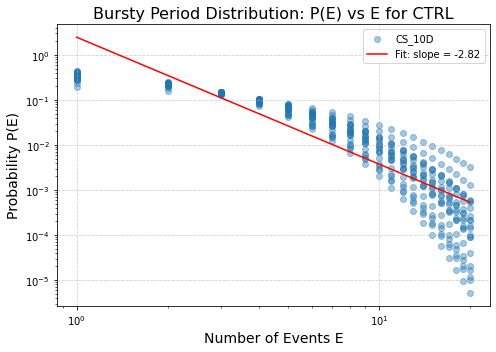

CS_10D - Slope (power-law exponent): -2.82


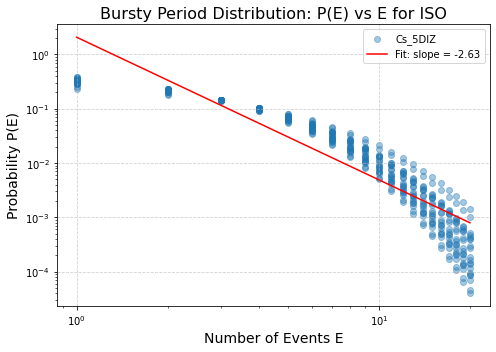

Cs_5DIZ - Slope (power-law exponent): -2.63


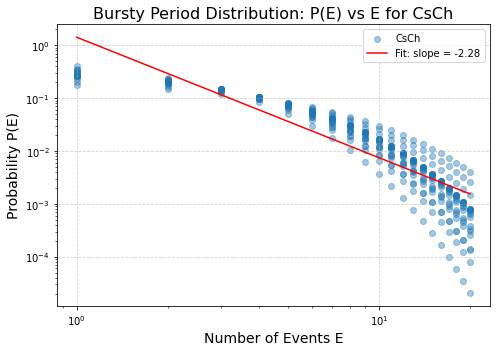

CsCh - Slope (power-law exponent): -2.28


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.linear_model import LinearRegression

# Define function to calculate the probability distribution of inter-event times
def degree_probability(times):
    unique_times, counts = np.unique(times, return_counts=True)
    probabilities = counts / sum(counts)  # Normalize counts to get probabilities
    return unique_times, probabilities

# Define function to calculate P(E = n)
def calculate_P_E(n, C_delta_t):
    return (C_delta_t ** (n - 1)) * (1 - C_delta_t)

# Set the time window (Delta t) for bursty periods
Delta_t = 12  # Adjust this value based on your data

all_unique_times = []
all_probabilities = []
for TREATMENT in TREATMENTS:
    path = f"/srv/milky/drosophila-datasets/drosophila-isolation/data/processed/1_0_find_interactions/{TREATMENT}"
    files = fileio.load_files_from_folder(path)
    results = {}
    all_E_values = []
    all_P_E_values = []

    for group_name, group_path in files.items():
        df = pd.read_csv(group_path)
        event_times = df['start_of_interaction'].to_list()
        inter_event_times = np.diff(sorted(event_times))  # Calculate inter-event times
        unique_times, probabilities = degree_probability(inter_event_times)
        C_delta_t = np.sum(probabilities[unique_times <= Delta_t])  # Sum probabilities of inter-event times <= Delta_t
        max_events = 20  # Maximum number of events for plotting, adjust if needed
        P_E_values = []

        for n in range(1, max_events + 1):
            P_E = calculate_P_E(n, C_delta_t)
            P_E_values.append(P_E)

        all_E_values.extend(np.arange(1, max_events + 1))
        all_P_E_values.extend(P_E_values)

    # Convert E and P(E) values to log scale for power-law fitting
    log_E_values = np.log10(all_E_values)
    log_P_E_values = np.log10(all_P_E_values)

    # Step 1: Fit a linear model (linear regression) to the log-log data
    model = LinearRegression()
    model.fit(log_E_values.reshape(-1, 1), log_P_E_values)

    # Step 2: Get the slope (exponent of the power law)
    slope = model.coef_[0]

    # Step 3: Plotting the data and the fitted line
    plt.figure(figsize=(7, 5))
    plt.scatter(all_E_values, all_P_E_values, label=f'{TREATMENT}', alpha=0.4)
    plt.plot(all_E_values, 10 ** model.predict(log_E_values.reshape(-1, 1)), color='red', label=f'Fit: slope = {slope:.2f}')
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'Bursty Period Distribution: P(E) vs E for {renamed_treatments[TREATMENT]}', fontsize=16)
    plt.xlabel('Number of Events E', fontsize=14)
    plt.ylabel('Probability P(E)', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

    # Print the slope (exponent of the power law)
    print(f'{TREATMENT} - Slope (power-law exponent): {slope:.2f}')


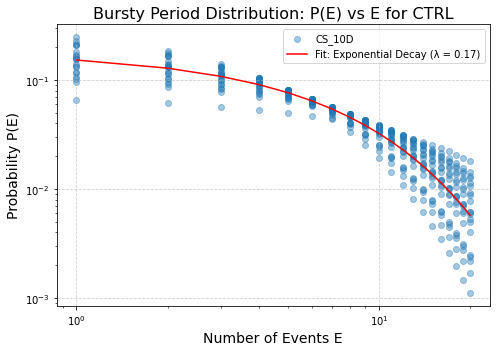

CS_10D - Exponential Decay Parameter (lambda): 0.17


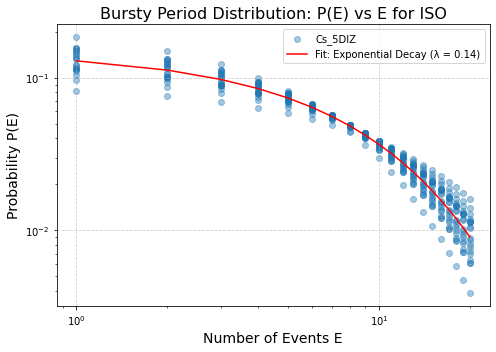

Cs_5DIZ - Exponential Decay Parameter (lambda): 0.14


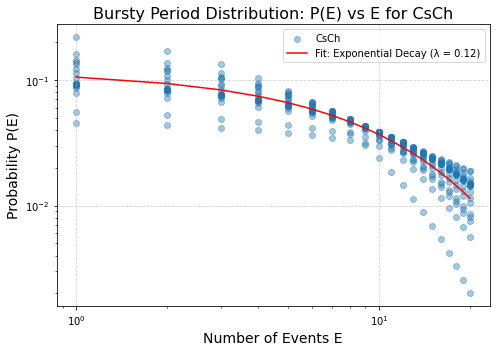

CsCh - Exponential Decay Parameter (lambda): 0.12


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from scipy.optimize import curve_fit

# Define function to calculate the probability distribution of inter-event times
def degree_probability(times):
    unique_times, counts = np.unique(times, return_counts=True)
    probabilities = counts / sum(counts)  # Normalize counts to get probabilities
    return unique_times, probabilities

# Define function to calculate P(E = n)
def calculate_P_E(n, C_delta_t):
    return (C_delta_t ** (n - 1)) * (1 - C_delta_t)

# Define exponential function for fitting
def exponential_func(E, A, lambda_):
    return A * np.exp(-lambda_ * E)

# Set the time window (Delta t) for bursty periods
Delta_t = 24  # Adjust this value based on your data

all_unique_times = []
all_probabilities = []
for TREATMENT in TREATMENTS:
    path = f"/srv/milky/drosophila-datasets/drosophila-isolation/data/processed/1_0_find_interactions/{TREATMENT}"
    files = fileio.load_files_from_folder(path)
    results = {}
    all_E_values = []
    all_P_E_values = []

    for group_name, group_path in files.items():
        df = pd.read_csv(group_path)
        event_times = df['start_of_interaction'].to_list()
        inter_event_times = np.diff(sorted(event_times))  # Calculate inter-event times
        unique_times, probabilities = degree_probability(inter_event_times)
        C_delta_t = np.sum(probabilities[unique_times <= Delta_t])  # Sum probabilities of inter-event times <= Delta_t
        max_events = 20  # Maximum number of events for plotting, adjust if needed
        P_E_values = []

        for n in range(1, max_events + 1):
            P_E = calculate_P_E(n, C_delta_t)
            P_E_values.append(P_E)

        all_E_values.extend(np.arange(1, max_events + 1))
        all_P_E_values.extend(P_E_values)

    # Step 1: Fit an exponential decay function to the data
    E_values = np.array(all_E_values)
    P_E_values = np.array(all_P_E_values)

    max_P_E = max(P_E_values)
    avg_E = np.mean(E_values)
    p0 = [max_P_E, 1 / avg_E]  # Adjust initial guess based on the data

    # Use curve fitting to find A and lambda
    params, covariance = curve_fit(exponential_func, E_values, P_E_values, p0=p0)  # Initial guess for A and lambda
    A, lambda_ = params

    # Step 2: Generate the fitted curve
    fitted_P_E_values = exponential_func(E_values, *params)
    # Step 3: Plotting the data and the fitted exponential curve
    plt.figure(figsize=(7, 5))
    plt.scatter(E_values, P_E_values, label=f'{TREATMENT}', alpha=0.4)
    plt.plot(E_values[:max_events], fitted_P_E_values[:max_events], color='red', label=f'Fit: Exponential Decay (λ = {lambda_:.2f})')

    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'Bursty Period Distribution: P(E) vs E for {renamed_treatments[TREATMENT]}', fontsize=16)
    plt.xlabel('Number of Events E', fontsize=14)
    plt.ylabel('Probability P(E)', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

    # Print the decay rate (lambda)
    print(f'{TREATMENT} - Exponential Decay Parameter (lambda): {lambda_:.2f}')


In [196]:
# event_times
# max(inter_event_times)
# unique_times
# C_delta_t = np.sum(probabilities[unique_times <= Delta_t])

143